# RESCUE
**Renewable Energy Salient Combined Uncertainty Estimator**

## *Description:*
A machine-learning based framework to quantify the short-term uncertainty in netload forecast developed by E3. 
The main strucutre of the model include a two layer artificial neural net with the pinball loss function as objective. Conditional on combinations of input, the model should be able to output quantile forecast for the net-load forecast error.

This notebook contains the work load of ingesting pre-processed data, set up cross validation folds, training and deployment, and calling functions for diagnostics. For detailed implementation of data preprocessing or quoted functions, please refer to other script files. This project is available in the [e3/RESCUE](https://github.com/e3-/RESCUE) Github online repository. 

In the preliminary use case, the quantile forecast is trained on the response variable. For CAISO, as we are using RTPD forecast - RTD forecast as the response variable, the quantiles is actually on forecast difference rather than forecast error. Nevertheless, the model structure and the logic still holds the same. The code supports multi-output, multi-objective learning. For example, in addition to producing the quantile forecast of Net Load (RTPD-RTD) forecast error, the model can be trained to simultaneously trained to predict the Load (RTPD-RTD), Solar (RTPD-RTD) and Wind (RTPD-RTD) forecast error which would otherwise be embedded in the Net Load. The objectives can be weighted per user's judgement of relative importance.

## *Highlights:*
1. Incorporating a wide gamut of information: weather, calendar, forecast, and lagged error aware. 
2. Inherrent handles resource correlation as solar,wind, and load errors are co-trained within the model.
3. Produces multiple prediction intervals for expected error in netload, load, solar and wind forecasting, for cherry picking down-stream
4. Model agnostic. No requirement on knowledge of the inner workings of the netload forecast
5. Adheres to best practice in statistics: cross validation, normalization, early-stopping, etc.

## *To-dos:*
1. Standardize the output for stability;
2. Loop in Charlie's section on metrics
3. Delete any cells at the end that were used as scratch space
4. Check directionality of example plots on chosen days (ts_ranges)
5. Fix datetime-stamps in section 5's plots when datetime of observation is on x-axis

## *Authors:* 
Yuchi Sun, Vignesh Venugopal, Charles Gulian

In [5]:
# Import third party packages
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt 

# Import self defined packages
import cross_val
import utility
import diagnostics

# 0. User Inputs
## 0.1 Model Training and Inference

In [6]:
# Name of the model to either be trained from scratch or to be restored for diagnostics. Recommend to include version number
model_name = 'rescue_v1_1_multi_objective'

# Target quantiles of the prediction 
PI_percentiles = np.array([0.025, 0.05, 0.25, 0.5,0.75, 0.95, 0.975]) # quantiles to predict

# Structural parameter of the ANN network
num_neurons = 10
activation_type = 'relu'
# This determines relative importance of our outputs. Order MUST match order of output variables in trainval_outputs data
loss_wts = [np.sqrt(3), 1.0, 1.0, 1.0]
num_outputs = len(loss_wts)

# Cross validation parameters
num_cv_folds = 10 # number of cross validation folds

# Training parameters
batch_size = 64 # size of each mini-batch in the SGD
max_epochs = 50 # Maximum number of epochs in training. In each epoch, each training data is used exactly once
optimizer_choice = 'adam' # Optimizer choice. Default to ADAM, a popular choice that have 1st and 2nd order momentum

# Early stopping parameters
early_stop_monitor = 'val_loss' # The metrics to watch when deciding whether to stop. Recommendation: Validation loss as in 'val_loss'
early_stop_min_delta = 0.5 # if the difference/decrease in loss is less than min_delta, the model is considered no longer improving
early_stop_patience = 3 # For number of patience epochs, observe if the model has improved more than min_delta
early_stop_verbosity = 1 # 0: no output, 1: some output, 2: full output

# Check points parameters
ckpt_monitor = 'val_loss' # Check points are only saved when there is an improvement in ckpt monitor

# Losses and Metrics log parameters
log_activation_freq = 0 # the frequency of logging hidden layer activation's histogram. Default to not log
log_update_freq = 'epoch' # The frequency of logging. Default to record at the end of every epoch


## 0.2 Diagnostics and Visualizations Associated with Trained Model

In [7]:
# Resolution of plots to be made
default_dpi = 300

# Define the mapping between internal feature (model input) name and feature label used in plotting
label_to_feature_map = {"Solar_RTPD_Forecast_T+1":"Solar Generation (MW)",
                       "Wind_RTPD_Forecast_T+1":"Wind Generation (MW)",
                       "Load_RTPD_Forecast_T+1":"Load (MW)",
                       "Days_from_Start_Date_T+1":"Date of Observation",
                       "Hour_Angle_T+1":"Hour",
                       "Day_Angle_T+1":"Month"}

# Define the mapping between internal response (model output) name and response label used in plotting
label_to_response_map = {"Net_Load_Forecast_Error_T+1":"Net Load",
                       "Load_Forecast_Error_T+1":"Load",
                       "Solar_Forecast_Error_T+1":"Solar",
                       "Wind_Forecast_Error_T+1":"Wind"}

# Training and validation loss comparison for multiple folds
x_jitter = 0.1
metrics_to_idx_map = {'Loss (MW)':0, 'Coverage Probability (%)':1}
metrics_to_compare = ['Loss (MW)', 'Coverage Probability (%)'] # choose in metrics_to_idx_map's keys

# Time series
ts_ranges = ['20170201','20170501','20170801','20171101'] # the example range of time series to plot

# Do you wish to save diagnostic figures?
save_fig_flag = True

# Do you wish to see diagnostic figures for a specific month and/or year?
# Leave with value "All" if you want the plots to be based on the entire dataset
diagnostics_for_year = 2019
diagnostics_for_month = 1

# TODO: If this is to be shown permanently in graphs going forward, make it a part of dir_str
# Define path to historical FRP reserves data. Set this variable to None if not applicable
hist_rtpd_reserves_path = "S:\\E3 Projects\\ARPA_E _PERFORM\\Data\\Historical_FRP\\caiso_oasis\\output\\processed\\Flex_Ramp_Req_RTPD.csv"

# TODO: Take a call on whether we should permanently switch the direction of our forecast error definition
switch_forecast_direction_flag = True

# We have 'k' models wherein k is the number of cv folds. Pick one of the models to load predictions
# and calculate diagnostic metrics and create diagnostic plots for
model_idx = 0

# Do you wish to save the coincident model net load predictions and ground truth data being identified and 
# plotted in section 5.3?
save_net_load_pred_truth_data_flag = True

# 1. Data Ingestion

Load in pre-processed trainval dataset that includes all input features/ output response(s) for both training and validation. Prepare the cross validation splitting masks. Set up directory structure to store intermediate (`log`, `checkpoints`) and final outputs (`models`, `outputs`,`diagnostics`).


In [8]:
# Load in/ Create folder structure for the current model
dir_str = utility.Dir_Structure(model_name = model_name)

# Read in input and output of the training and validation samples from data pipeline. 
# This should be an output of the data_preprocessing script
input_trainval = pd.read_pickle(dir_str.input_trainval_path)
output_trainval = pd.read_pickle(dir_str.output_trainval_path)
assert input_trainval.shape[0] == output_trainval.shape[0], "Input and output shape mismatch!"
if num_outputs > 1:
    assert output_trainval.shape[1] == num_outputs, "Number of 'loss_wts' must equal number of outputs"
n_samples = input_trainval.shape[0]

# Use cross validation script to conduct intra-day consecutive trainval splitting. The number of folds is 
# determined by num_cv_folds. The data of the same day would not end up separately in training and validation
# to not overestimate model performance.
val_masks_all_folds = cross_val.get_CV_masks(input_trainval.index, num_cv_folds, dir_str.shuffled_indices_path)

# confirm the PI percentiles are symmetrical and 0.5 is one of the target quantile
for PI in PI_percentiles:
    assert np.allclose(1-PI_percentiles, PI_percentiles[::-1]), "Not all PI intervals are constructed symmetrically!"
assert 0.5 in PI_percentiles, "Median forecast (P50) must be produced!"

Day block shuffling pre-determnined....
Done....
Creating train val masks for each fold....
Train and val masks are ready!


# 2. Model Definition
Define the various component of the model that are active at various stage of the model life cycle. Before training: model structure, loss function. During training: call backs and metrics. After training: Saving functions. 

## 2.1 Model Structure.
The RESCUE model is built with the Keras [functional API](https://www.tensorflow.org/guide/keras#model_subclassing). As it stands right now, it is a two layer ANN network with a pre-processing normalization layer. Rectified linear units is used as the activation function for the hidden layers, while the last layer is a direct linear regression.                        

In [4]:
# Create a model that include the normalization layer
inputs = tf.keras.Input(shape=input_trainval.shape[1:])

# Create a Normalization layer and set its internal state using the training data
normalizer = tf.keras.layers.experimental.preprocessing.Normalization(name = 'Normalization')
norm_inputs = normalizer(inputs)

# A two-layer ANN network for regression
dense1 = tf.keras.layers.Dense(num_neurons, activation=activation_type)
hidden1 = dense1(norm_inputs)
dense2 = tf.keras.layers.Dense(num_neurons, activation=activation_type)
hidden2 = dense2(hidden1)
dense3 = tf.keras.layers.Dense(num_outputs)
outputs = dense3(hidden2)

# define model from inputs to outputs
rescue_model = tf.keras.Model(inputs, outputs)

## 2.2 Loss Function

The pinball loss function is used here to provide a quantile forecast rather than a median forecast. With increasing sample size, the pinball loss would converge to the quantile forecast of a variable conditional on the input variable. The quantile is given by a parameter `tau`, which is set in the user input as PI percentiles. 

One property of the pinball loss is that for 0% and 100% percentile, the pinball loss is always 0 no matter the model and parameter choice, while the median forecast have the highest loss. So comparing the losses across different quantiles makes little sense, and is advised against. For more information on pinball losses, check out [this wiki](https://en.wikipedia.org/wiki/Quantile_regression).

In case of multi-output, multi-objective regression, the loss corresponding to each output can be weighted by the user to differentiate the amt of importance he/she wishes to give to each output. The loss that the model will ultimately try to minimize would be the wt.avg loss

In [10]:
class PinballLoss(tf.keras.losses.Loss):
    def __init__(self, tau=0.5, loss_wts=[1], name="pinball_loss"):
        super().__init__(name=name)
        self.tau = tau # the target quantile
        self.loss_wts = loss_wts # Relative importance of loss corresponding to each output

    def call(self, y_true, y_pred):
        err = y_true - y_pred # the convention is always true - pred
        # essentially, quantile regression takes two region. For values bigger than the quantile forecast,
        # they are weighted by 1-tau, while for values smaller than the forecast it's weighted by tau.
        loss_for_each_output_var_of_each_sample = tf.math.maximum(self.tau * err, (self.tau - 1) * err)
        # Get weighted avg loss for each sample
        loss_for_each_sample = tf.math.reduce_mean(tf.math.multiply(loss_for_each_output_var_of_each_sample, self.loss_wts),
                                                   axis = 1)
        # Now get a single loss across all samples that make up the batch
        skewed_mse = tf.math.reduce_mean(loss_for_each_sample, axis=0)

        return skewed_mse

## 2.3 Metrics

In tensorflow terminology, metrics are quantities that are calculated as the training goes on to aid your judgement on model's fitness and completeness. In our use cases, we define two metrics for this purpose: coverage probability and average interval width.

For prediction intervals, coverage probability refers to how often are the actual forecast included in the prediciton interval bands. Here we slightly modify the definition and refers to how often are the actual forecast smaller than the target quantile. For a well behaving model, the CP would converge to target quantile tau.

For average interval width, it normally refers to the width of a prediction interval band. Again, we make a slight modification here. Since in practice, the forecast for quantiles above 50% are upwards reserve and normally positive, and below 50% are downwards reserve and normally negative, we are simply using the quantile forecast's absolute distance to 0 as the interval width here. For interpretation, we are looking for smaller requirement for better band width, but also high flexibitliy wrt to varying condidtions.


In [11]:
class CoverageProbability(tf.keras.metrics.Metric):
    def __init__(self, name = 'CP',**kwargs):
        super(CoverageProbability, self).__init__(name = name, **kwargs)
        self.coverage_probability = self.add_weight(name = 'CP', initializer="zeros", dtype = tf.float64)
        # the cumulative number of samples and the number of samples smaller than current quantile forecast
        self.cum_n_samples = self.add_weight(name = 'n_samples', initializer="zeros", dtype = tf.int32)
        self.cum_n_covered = self.add_weight(name = 'n_covered', initializer="zeros", dtype = tf.int32)
        
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        # the state would be updated everytime we have a new calculation
        self.cum_n_samples.assign_add(tf.size(y_pred, out_type=tf.int32))
        self.cum_n_covered.assign_add(tf.math.count_nonzero(tf.math.less_equal(y_true,y_pred), dtype = tf.int32))
        # cp = n_covered/n_samples
        self.coverage_probability.assign(tf.math.divide(self.cum_n_covered, self.cum_n_samples))

    def result(self):
        return self.coverage_probability

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.coverage_probability.assign(0.0)
        


## 2.4 Callbacks

In tensorflow terminology, callbacks are functions that get executed with certain frequency during training. For our purpose, all the callbacks happen once per epoch and we are using three types of callbacks: Early stopping, check points, and tensor boards. Saving the model is not necessarily a callback, but it also get executed once after the training for the model is complete, so is included in this segment.

1. Early stopping stops the training when certain criteria is met. In general the criteria is that when `monitor` did not improve by more than `min_delta` in `patience` epoch(s), then the training is stopped. This is a way to effectively prevent overfitting to the training data, so the monitor is most often validation loss.  
2. Check points are periodical snap shot of parameter weights saved in case the model training is unexpectedly stopped.  We are saving the `checkpoints`,`logs`, and`trained models` in different folders for different taus and folds.
3. Saving is very similar to check points. Difference is that check points are conducted at the end of every epoch, while saving only happens at the end of training session.
4. The tensorboard callback allow us to visualize and observe losses and all metrics in a pre-compiled tensorboard interface. It can even visualize losses and metrics for multiple folds and taus.

In [12]:
# Early stopping stops the training when certain criteria is met.
cb_early_stopping = tf.keras.callbacks.EarlyStopping(monitor=early_stop_monitor, min_delta=early_stop_min_delta, 
                                                     patience=early_stop_patience, verbose=early_stop_verbosity)

# For the save best only parameter: we will overwrite the current checkpoint if and only if the `val_loss` 
# score has improved. Different fold and tau would end up in different ckpts_dir folder
def get_cb_check_points(tau, fold_idx):
    # make sure models for different tau go to different directories
    ckpts_dir = os.path.join(dir_str.ckpts_dir, "tau_{:.1%}".format(tau),"fold_#{}".format(fold_idx))
    if not os.path.exists(ckpts_dir):
        os.makedirs(ckpts_dir)
    cb_check_points = tf.keras.callbacks.ModelCheckpoint(filepath=ckpts_dir, save_best_only=True, monitor= ckpt_monitor, verbose=0)
    return cb_check_points


# Currrently not logging the histogram of activation and embedding layers. Write log per epoch.
def get_cb_tensor_board(tau, fold_idx):
    # make sure models for different tau and fold would get logged in different directory
    logs_dir = os.path.join(dir_str.logs_dir, "tau_{:.1%}".format(tau),"fold_#{}".format(fold_idx))
    if not os.path.exists(logs_dir):
        os.makedirs(logs_dir)
    cb_tensor_board = tf.keras.callbacks.TensorBoard(logs_dir, histogram_freq= log_activation_freq, 
                                                     embeddings_freq=0,  update_freq=log_update_freq)  
    return cb_tensor_board

# Save the model by the end of each training session. Might be replacible by checkpoints.
def save_rescue_model(model, tau, fold_idx):
    # make sure models for different tau and fold would get logged in different directory
    models_dir = os.path.join(dir_str.models_dir, "tau_{:.1%}".format(tau),"fold_#{}".format(fold_idx))
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)
    
    model.save(models_dir)
    return None   

# 3. Model Training

Training is the process where the parameter of a model changes to reduce some loss function. In our specific case, we are conducting training separtely for each target quantile and each fold. We first split data into training and validation based on current fold number, and then initialize a new model to fit to the training data until the pinball loss meet some stopping criteria, i.e. showing no significant decrease.


In [16]:
rescue_model_set = {} # intialized container for TF models. Indexed by (tau, fold_idx)
history = {} # intialized container for the training history of models. Indexed by (tau, fold_idx)

# loop through different target quantiles and cross validation folds
for tau in PI_percentiles:
    print("Training model for Prediction interval: {:.1%}".format(tau))
    for fold_idx in range(num_cv_folds):
        print("Cross Validation fold #", fold_idx+1)
        
        # Split into training and validation dataset based on the CV validation masks generated in section 1.
        input_train, output_train = input_trainval[~val_masks_all_folds[fold_idx]], output_trainval[~val_masks_all_folds[fold_idx]]
        input_val, output_val = input_trainval[val_masks_all_folds[fold_idx]], output_trainval[val_masks_all_folds[fold_idx]]
        
        # retain value only and cast to 'float32'. Single precision calculate a lot faster than double precision.
        input_train = input_train.values.astype('float32')
        output_train = output_train.values.astype('float32')
        input_val = input_val.values.astype('float32')
        output_val = output_val.values.astype('float32')

        # Using tf.data API to batch and shuffle the dataset. For shuffling, the buffer size should be bigger than the total 
        # sample count. Or else only the first buffle size of samples would be shuffled 
        train_ds = tf.data.Dataset.from_tensor_slices((input_train, output_train)).shuffle(buffer_size= n_samples).batch(batch_size)
        val_ds = tf.data.Dataset.from_tensor_slices((input_val, output_val)).shuffle(buffer_size = n_samples).batch(batch_size)

        # Make a fresh clone of the rescue model for the specific quantile and fold
        rescue_model_set[(tau, fold_idx)] = tf.keras.models.clone_model(rescue_model)
        # For some layers the paramers are not trainable, and is adapted at the begining to data. E.g.:Normalization layer 
        rescue_model_set[(tau, fold_idx)].get_layer('Normalization').adapt(input_trainval.values)
        # Compiling the loss, optimizer, metrics, and model into one compiled instance
        rescue_model_set[(tau, fold_idx)].compile(loss=PinballLoss(tau=tau, loss_wts=loss_wts),
                                                  optimizer=optimizer_choice, metrics=[CoverageProbability()])
        
        # The training process. Passing in callbacks to use in mid training 
        history[(tau, fold_idx)]= rescue_model_set[(tau, fold_idx)].fit(train_ds, validation_data=val_ds, epochs=max_epochs,
                                                                        callbacks=[cb_early_stopping, get_cb_tensor_board(tau, fold_idx)])
        
        # Save the trained rescue model for each target percentile and fold
        save_rescue_model(rescue_model_set[(tau, fold_idx)], tau, fold_idx)


Training model for Prediction interval: 2.5%
Cross Validation fold # 1
Train for 1400 steps, validate for 156 steps
Epoch 1/50
1400/1400 [==============================] - 3s 2ms/step - loss: 42.7301 - CP: 0.1512 - val_loss: 24.6723 - val_CP: 0.1400
Epoch 2/50
1400/1400 [==============================] - 2s 2ms/step - loss: 23.1755 - CP: 0.0903 - val_loss: 22.7010 - val_CP: 0.0876
Epoch 3/50
1400/1400 [==============================] - 2s 2ms/step - loss: 21.4937 - CP: 0.0705 - val_loss: 21.2750 - val_CP: 0.0693
Epoch 4/50
1400/1400 [==============================] - 2s 1ms/step - loss: 19.9420 - CP: 0.0604 - val_loss: 19.9634 - val_CP: 0.0597
Epoch 5/50
1400/1400 [==============================] - 2s 1ms/step - loss: 18.4636 - CP: 0.0539 - val_loss: 19.0195 - val_CP: 0.0535
Epoch 6/50
1400/1400 [==============================] - 2s 1ms/step - loss: 17.5455 - CP: 0.0494 - val_loss: 18.1635 - val_CP: 0.0491
Epoch 7/50
1400/1400 [==============================] - 2s 1ms/step - loss: 16.9

1400/1400 [==============================] - 2s 2ms/step - loss: 15.8643 - CP: 0.0316 - val_loss: 15.3244 - val_CP: 0.0316
Epoch 18/50
1400/1400 [==============================] - 2s 2ms/step - loss: 15.5682 - CP: 0.0312 - val_loss: 14.9820 - val_CP: 0.0312
Epoch 19/50
1400/1400 [==============================] - 2s 2ms/step - loss: 15.3285 - CP: 0.0308 - val_loss: 14.7975 - val_CP: 0.0308
Epoch 20/50
1400/1400 [==============================] - 2s 2ms/step - loss: 15.1239 - CP: 0.0305 - val_loss: 14.5714 - val_CP: 0.0305
Epoch 21/50
1400/1400 [==============================] - 2s 2ms/step - loss: 14.9486 - CP: 0.0302 - val_loss: 14.4226 - val_CP: 0.0301
Epoch 22/50
1400/1400 [==============================] - 2s 2ms/step - loss: 14.8067 - CP: 0.0299 - val_loss: 14.3277 - val_CP: 0.0299
Epoch 00022: early stopping
INFO:tensorflow:Assets written to: C:\Users\vignesh.venugopal\PycharmProjects\RESCUE\models\rescue_v1_1_multi_objective\tau_2.5%\fold_#5\assets
Cross Validation fold # 7
Trai

1400/1400 [==============================] - 2s 2ms/step - loss: 25.5339 - CP: 0.0592 - val_loss: 25.7324 - val_CP: 0.0592
Epoch 15/50
1400/1400 [==============================] - 2s 2ms/step - loss: 25.1084 - CP: 0.0584 - val_loss: 25.3621 - val_CP: 0.0584
Epoch 16/50
1400/1400 [==============================] - 2s 2ms/step - loss: 24.7604 - CP: 0.0578 - val_loss: 25.0198 - val_CP: 0.0577
Epoch 17/50
1400/1400 [==============================] - 2s 2ms/step - loss: 24.4808 - CP: 0.0571 - val_loss: 24.8122 - val_CP: 0.0571
Epoch 18/50
1400/1400 [==============================] - 2s 2ms/step - loss: 24.2413 - CP: 0.0566 - val_loss: 24.5244 - val_CP: 0.0566
Epoch 19/50
1400/1400 [==============================] - 2s 2ms/step - loss: 24.0391 - CP: 0.0562 - val_loss: 24.3107 - val_CP: 0.0561
Epoch 20/50
1400/1400 [==============================] - 2s 2ms/step - loss: 23.8490 - CP: 0.0557 - val_loss: 24.1669 - val_CP: 0.0557
Epoch 21/50
1400/1400 [==============================] - 2s 2ms/ste

1400/1400 [==============================] - 2s 2ms/step - loss: 23.9941 - CP: 0.0573 - val_loss: 23.2938 - val_CP: 0.0572
Epoch 22/50
1400/1400 [==============================] - 2s 2ms/step - loss: 23.8152 - CP: 0.0569 - val_loss: 23.1685 - val_CP: 0.0569
Epoch 23/50
1400/1400 [==============================] - 2s 2ms/step - loss: 23.6383 - CP: 0.0566 - val_loss: 23.0379 - val_CP: 0.0566
Epoch 24/50
1400/1400 [==============================] - 3s 2ms/step - loss: 23.4817 - CP: 0.0563 - val_loss: 22.8310 - val_CP: 0.0563
Epoch 25/50
1400/1400 [==============================] - 3s 2ms/step - loss: 23.3334 - CP: 0.0561 - val_loss: 22.7262 - val_CP: 0.0560
Epoch 00025: early stopping
INFO:tensorflow:Assets written to: C:\Users\vignesh.venugopal\PycharmProjects\RESCUE\models\rescue_v1_1_multi_objective\tau_5.0%\fold_#5\assets
Cross Validation fold # 7
Train for 1400 steps, validate for 156 steps
Epoch 1/50
1400/1400 [==============================] - 3s 2ms/step - loss: 54.0605 - CP: 0.18

1400/1400 [==============================] - 2s 2ms/step - loss: 72.3323 - CP: 0.2674 - val_loss: 73.9258 - val_CP: 0.2671
Epoch 7/50
1400/1400 [==============================] - 2s 2ms/step - loss: 70.2569 - CP: 0.2649 - val_loss: 72.5460 - val_CP: 0.2645
Epoch 8/50
1400/1400 [==============================] - 2s 2ms/step - loss: 69.1465 - CP: 0.2629 - val_loss: 71.8009 - val_CP: 0.2629
Epoch 9/50
1400/1400 [==============================] - 2s 2ms/step - loss: 68.4055 - CP: 0.2617 - val_loss: 70.9673 - val_CP: 0.2615
Epoch 10/50
1400/1400 [==============================] - 2s 2ms/step - loss: 67.7541 - CP: 0.2606 - val_loss: 70.4051 - val_CP: 0.2605
Epoch 11/50
1400/1400 [==============================] - 2s 2ms/step - loss: 67.1284 - CP: 0.2598 - val_loss: 69.7676 - val_CP: 0.2598
Epoch 12/50
1400/1400 [==============================] - 2s 2ms/step - loss: 66.5079 - CP: 0.2591 - val_loss: 69.1246 - val_CP: 0.2590
Epoch 13/50
1400/1400 [==============================] - 2s 2ms/step -

1400/1400 [==============================] - 2s 2ms/step - loss: 57.9765 - CP: 0.2506 - val_loss: 58.3050 - val_CP: 0.2506
Epoch 29/50
1400/1400 [==============================] - 2s 2ms/step - loss: 57.7654 - CP: 0.2506 - val_loss: 57.9854 - val_CP: 0.2506
Epoch 30/50
1400/1400 [==============================] - 2s 2ms/step - loss: 57.5624 - CP: 0.2506 - val_loss: 57.9230 - val_CP: 0.2506
Epoch 31/50
1400/1400 [==============================] - 2s 2ms/step - loss: 57.3672 - CP: 0.2506 - val_loss: 57.8280 - val_CP: 0.2506
Epoch 00031: early stopping
INFO:tensorflow:Assets written to: C:\Users\vignesh.venugopal\PycharmProjects\RESCUE\models\rescue_v1_1_multi_objective\tau_25.0%\fold_#1\assets
Cross Validation fold # 3
Train for 1400 steps, validate for 156 steps
Epoch 1/50
1400/1400 [==============================] - 3s 2ms/step - loss: 87.7218 - CP: 0.3006 - val_loss: 82.3517 - val_CP: 0.2997
Epoch 2/50
1400/1400 [==============================] - 2s 2ms/step - loss: 81.6544 - CP: 0.28

1400/1400 [==============================] - 2s 2ms/step - loss: 57.1472 - CP: 0.2495 - val_loss: 59.2814 - val_CP: 0.2495
Epoch 33/50
1400/1400 [==============================] - 2s 2ms/step - loss: 56.8328 - CP: 0.2495 - val_loss: 59.1960 - val_CP: 0.2495
Epoch 34/50
1400/1400 [==============================] - 2s 2ms/step - loss: 56.5362 - CP: 0.2495 - val_loss: 58.6577 - val_CP: 0.2495
Epoch 35/50
1400/1400 [==============================] - 2s 2ms/step - loss: 56.2263 - CP: 0.2495 - val_loss: 58.4096 - val_CP: 0.2495
Epoch 36/50
1400/1400 [==============================] - 2s 2ms/step - loss: 55.9540 - CP: 0.2496 - val_loss: 58.1264 - val_CP: 0.2496
Epoch 37/50
1400/1400 [==============================] - 2s 2ms/step - loss: 55.7125 - CP: 0.2496 - val_loss: 57.9580 - val_CP: 0.2496
Epoch 38/50
1400/1400 [==============================] - 2s 2ms/step - loss: 55.4533 - CP: 0.2496 - val_loss: 57.6584 - val_CP: 0.2496
Epoch 39/50
1400/1400 [==============================] - 2s 2ms/ste

1400/1400 [==============================] - 2s 2ms/step - loss: 55.3690 - CP: 0.2518 - val_loss: 55.4156 - val_CP: 0.2518
Epoch 43/50
1400/1400 [==============================] - 2s 1ms/step - loss: 55.2390 - CP: 0.2517 - val_loss: 55.2438 - val_CP: 0.2517
Epoch 44/50
1400/1400 [==============================] - 2s 2ms/step - loss: 55.1140 - CP: 0.2517 - val_loss: 55.0346 - val_CP: 0.2517
Epoch 00044: early stopping
INFO:tensorflow:Assets written to: C:\Users\vignesh.venugopal\PycharmProjects\RESCUE\models\rescue_v1_1_multi_objective\tau_25.0%\fold_#7\assets
Cross Validation fold # 9
Train for 1400 steps, validate for 156 steps
Epoch 1/50
1400/1400 [==============================] - 2s 2ms/step - loss: 88.9059 - CP: 0.2961 - val_loss: 81.8377 - val_CP: 0.2910
Epoch 2/50
1400/1400 [==============================] - 2s 2ms/step - loss: 84.9749 - CP: 0.2746 - val_loss: 80.7204 - val_CP: 0.2729
Epoch 3/50
1400/1400 [==============================] - 2s 2ms/step - loss: 83.7267 - CP: 0.266

1400/1400 [==============================] - 3s 2ms/step - loss: 75.8075 - CP: 0.4974 - val_loss: 78.2614 - val_CP: 0.4974
Epoch 26/50
1400/1400 [==============================] - 2s 2ms/step - loss: 75.3626 - CP: 0.4973 - val_loss: 77.8862 - val_CP: 0.4973
Epoch 27/50
1400/1400 [==============================] - 2s 2ms/step - loss: 74.9866 - CP: 0.4972 - val_loss: 77.3666 - val_CP: 0.4971
Epoch 28/50
1400/1400 [==============================] - 2s 2ms/step - loss: 74.6046 - CP: 0.4971 - val_loss: 76.9192 - val_CP: 0.4970
Epoch 29/50
1400/1400 [==============================] - 2s 2ms/step - loss: 74.2746 - CP: 0.4970 - val_loss: 76.6796 - val_CP: 0.4970
Epoch 30/50
1400/1400 [==============================] - 2s 2ms/step - loss: 73.9255 - CP: 0.4970 - val_loss: 76.3898 - val_CP: 0.4970
Epoch 31/50
1400/1400 [==============================] - 2s 2ms/step - loss: 73.6047 - CP: 0.4970 - val_loss: 76.0410 - val_CP: 0.4970
Epoch 32/50
1400/1400 [==============================] - 2s 2ms/ste

1400/1400 [==============================] - 2s 2ms/step - loss: 71.7672 - CP: 0.5008 - val_loss: 71.7351 - val_CP: 0.5008
Epoch 36/50
1400/1400 [==============================] - 2s 1ms/step - loss: 71.5378 - CP: 0.5008 - val_loss: 71.7962 - val_CP: 0.5008
Epoch 37/50
1400/1400 [==============================] - 2s 2ms/step - loss: 71.3174 - CP: 0.5008 - val_loss: 71.5677 - val_CP: 0.5008
Epoch 38/50
1400/1400 [==============================] - 2s 2ms/step - loss: 71.1226 - CP: 0.5008 - val_loss: 71.4178 - val_CP: 0.5008
Epoch 00038: early stopping
INFO:tensorflow:Assets written to: C:\Users\vignesh.venugopal\PycharmProjects\RESCUE\models\rescue_v1_1_multi_objective\tau_50.0%\fold_#1\assets
Cross Validation fold # 3
Train for 1400 steps, validate for 156 steps
Epoch 1/50
1400/1400 [==============================] - 3s 2ms/step - loss: 100.6246 - CP: 0.5009 - val_loss: 95.9159 - val_CP: 0.5024
Epoch 2/50
1400/1400 [==============================] - 2s 2ms/step - loss: 96.0387 - CP: 0.5

1400/1400 [==============================] - 2s 2ms/step - loss: 72.8073 - CP: 0.4959 - val_loss: 75.9726 - val_CP: 0.4959
Epoch 32/50
1400/1400 [==============================] - 2s 2ms/step - loss: 72.5495 - CP: 0.4960 - val_loss: 75.7186 - val_CP: 0.4959
Epoch 33/50
1400/1400 [==============================] - 2s 2ms/step - loss: 72.3116 - CP: 0.4960 - val_loss: 75.2974 - val_CP: 0.4960
Epoch 34/50
1400/1400 [==============================] - 2s 1ms/step - loss: 72.0978 - CP: 0.4961 - val_loss: 75.1280 - val_CP: 0.4961
Epoch 35/50
1400/1400 [==============================] - 2s 2ms/step - loss: 71.9042 - CP: 0.4962 - val_loss: 74.9565 - val_CP: 0.4962
Epoch 36/50
1400/1400 [==============================] - 2s 2ms/step - loss: 71.7152 - CP: 0.4963 - val_loss: 74.7240 - val_CP: 0.4963
Epoch 37/50
1400/1400 [==============================] - 2s 2ms/step - loss: 71.5344 - CP: 0.4964 - val_loss: 74.5494 - val_CP: 0.4964
Epoch 38/50
1400/1400 [==============================] - 2s 1ms/ste

1400/1400 [==============================] - 2s 2ms/step - loss: 76.5428 - CP: 0.4960 - val_loss: 78.0926 - val_CP: 0.4960
Epoch 22/50
1400/1400 [==============================] - 2s 2ms/step - loss: 76.1697 - CP: 0.4959 - val_loss: 77.7535 - val_CP: 0.4959
Epoch 23/50
1400/1400 [==============================] - 2s 2ms/step - loss: 75.7988 - CP: 0.4958 - val_loss: 77.2481 - val_CP: 0.4958
Epoch 24/50
1400/1400 [==============================] - 2s 2ms/step - loss: 75.4594 - CP: 0.4957 - val_loss: 77.2362 - val_CP: 0.4957
Epoch 25/50
1400/1400 [==============================] - 2s 2ms/step - loss: 75.1518 - CP: 0.4957 - val_loss: 76.6048 - val_CP: 0.4957
Epoch 26/50
1400/1400 [==============================] - 2s 2ms/step - loss: 74.8493 - CP: 0.4957 - val_loss: 76.3624 - val_CP: 0.4956
Epoch 27/50
1400/1400 [==============================] - 2s 2ms/step - loss: 74.5768 - CP: 0.4956 - val_loss: 75.9529 - val_CP: 0.4956
Epoch 28/50
1400/1400 [==============================] - 2s 2ms/ste

1400/1400 [==============================] - 2s 2ms/step - loss: 74.2569 - CP: 0.4995 - val_loss: 70.7501 - val_CP: 0.4995
Epoch 32/50
1400/1400 [==============================] - 2s 1ms/step - loss: 74.0034 - CP: 0.4995 - val_loss: 70.4879 - val_CP: 0.4995
Epoch 33/50
1400/1400 [==============================] - 2s 1ms/step - loss: 73.7833 - CP: 0.4996 - val_loss: 70.0671 - val_CP: 0.4997
Epoch 34/50
1400/1400 [==============================] - 2s 2ms/step - loss: 73.5400 - CP: 0.4997 - val_loss: 70.0133 - val_CP: 0.4997
Epoch 35/50
1400/1400 [==============================] - 2s 2ms/step - loss: 73.3237 - CP: 0.4997 - val_loss: 69.7965 - val_CP: 0.4997
Epoch 36/50
1400/1400 [==============================] - 2s 1ms/step - loss: 73.0862 - CP: 0.4997 - val_loss: 69.7644 - val_CP: 0.4998
Epoch 00036: early stopping
INFO:tensorflow:Assets written to: C:\Users\vignesh.venugopal\PycharmProjects\RESCUE\models\rescue_v1_1_multi_objective\tau_50.0%\fold_#8\assets
Cross Validation fold # 10
Tr

Epoch 2/50
1400/1400 [==============================] - 2s 2ms/step - loss: 79.5250 - CP: 0.7032 - val_loss: 81.7886 - val_CP: 0.7048
Epoch 3/50
1400/1400 [==============================] - 2s 2ms/step - loss: 78.6488 - CP: 0.7147 - val_loss: 81.0698 - val_CP: 0.7150
Epoch 4/50
1400/1400 [==============================] - 2s 2ms/step - loss: 77.9433 - CP: 0.7207 - val_loss: 80.2197 - val_CP: 0.7210
Epoch 5/50
1400/1400 [==============================] - 2s 2ms/step - loss: 77.0476 - CP: 0.7250 - val_loss: 79.1245 - val_CP: 0.7251
Epoch 6/50
1400/1400 [==============================] - 2s 2ms/step - loss: 75.9046 - CP: 0.7281 - val_loss: 77.7588 - val_CP: 0.7282
Epoch 7/50
1400/1400 [==============================] - 2s 1ms/step - loss: 74.5915 - CP: 0.7304 - val_loss: 76.4553 - val_CP: 0.7304
Epoch 8/50
1400/1400 [==============================] - 2s 2ms/step - loss: 73.1791 - CP: 0.7321 - val_loss: 75.1133 - val_CP: 0.7319
Epoch 9/50
1400/1400 [==============================] - 2s 2ms

1400/1400 [==============================] - 2s 2ms/step - loss: 61.2863 - CP: 0.7493 - val_loss: 61.5603 - val_CP: 0.7494
Epoch 25/50
1400/1400 [==============================] - 2s 2ms/step - loss: 60.9180 - CP: 0.7495 - val_loss: 61.2588 - val_CP: 0.7496
Epoch 26/50
1400/1400 [==============================] - 2s 2ms/step - loss: 60.5673 - CP: 0.7496 - val_loss: 61.0265 - val_CP: 0.7497
Epoch 27/50
1400/1400 [==============================] - 2s 2ms/step - loss: 60.2261 - CP: 0.7497 - val_loss: 60.5317 - val_CP: 0.7498
Epoch 28/50
1400/1400 [==============================] - 2s 2ms/step - loss: 59.8908 - CP: 0.7498 - val_loss: 60.1188 - val_CP: 0.7498
Epoch 29/50
1400/1400 [==============================] - 2s 2ms/step - loss: 59.5759 - CP: 0.7499 - val_loss: 59.9226 - val_CP: 0.7499
Epoch 30/50
1400/1400 [==============================] - 2s 2ms/step - loss: 59.2522 - CP: 0.7499 - val_loss: 59.5852 - val_CP: 0.7499
Epoch 31/50
1400/1400 [==============================] - 2s 2ms/ste

1400/1400 [==============================] - 2s 1ms/step - loss: 56.7020 - CP: 0.7517 - val_loss: 57.6075 - val_CP: 0.7517
Epoch 41/50
1400/1400 [==============================] - 2s 2ms/step - loss: 56.5011 - CP: 0.7517 - val_loss: 57.3539 - val_CP: 0.7517
Epoch 42/50
1400/1400 [==============================] - 2s 1ms/step - loss: 56.3023 - CP: 0.7517 - val_loss: 57.3322 - val_CP: 0.7518
Epoch 43/50
1400/1400 [==============================] - 2s 2ms/step - loss: 56.1278 - CP: 0.7518 - val_loss: 57.0808 - val_CP: 0.7518
Epoch 44/50
1400/1400 [==============================] - 2s 2ms/step - loss: 55.9562 - CP: 0.7518 - val_loss: 57.0544 - val_CP: 0.7517
Epoch 00044: early stopping
INFO:tensorflow:Assets written to: C:\Users\vignesh.venugopal\PycharmProjects\RESCUE\models\rescue_v1_1_multi_objective\tau_75.0%\fold_#2\assets
Cross Validation fold # 4
Train for 1400 steps, validate for 156 steps
Epoch 1/50
1400/1400 [==============================] - 2s 2ms/step - loss: 89.3448 - CP: 0.6

1400/1400 [==============================] - 2s 1ms/step - loss: 76.6557 - CP: 0.7303 - val_loss: 73.4822 - val_CP: 0.7305
Epoch 8/50
1400/1400 [==============================] - 2s 1ms/step - loss: 75.7455 - CP: 0.7323 - val_loss: 72.4359 - val_CP: 0.7324
Epoch 9/50
1400/1400 [==============================] - 2s 1ms/step - loss: 74.6904 - CP: 0.7340 - val_loss: 71.1650 - val_CP: 0.7341
Epoch 10/50
1400/1400 [==============================] - 2s 1ms/step - loss: 73.5261 - CP: 0.7354 - val_loss: 69.8863 - val_CP: 0.7356
Epoch 11/50
1400/1400 [==============================] - 2s 1ms/step - loss: 72.3249 - CP: 0.7367 - val_loss: 68.5709 - val_CP: 0.7369
Epoch 12/50
1400/1400 [==============================] - 2s 2ms/step - loss: 71.1703 - CP: 0.7379 - val_loss: 67.4992 - val_CP: 0.7379
Epoch 13/50
1400/1400 [==============================] - 2s 1ms/step - loss: 70.0758 - CP: 0.7387 - val_loss: 66.2541 - val_CP: 0.7387
Epoch 14/50
1400/1400 [==============================] - 2s 2ms/step 

1400/1400 [==============================] - 2s 2ms/step - loss: 63.7849 - CP: 0.7468 - val_loss: 64.8581 - val_CP: 0.7469
Epoch 25/50
1400/1400 [==============================] - 2s 2ms/step - loss: 63.4835 - CP: 0.7472 - val_loss: 64.5278 - val_CP: 0.7472
Epoch 26/50
1400/1400 [==============================] - 2s 2ms/step - loss: 63.1755 - CP: 0.7475 - val_loss: 64.2701 - val_CP: 0.7475
Epoch 27/50
1400/1400 [==============================] - 3s 2ms/step - loss: 62.8781 - CP: 0.7478 - val_loss: 63.8802 - val_CP: 0.7478
Epoch 28/50
1400/1400 [==============================] - 2s 2ms/step - loss: 62.6013 - CP: 0.7481 - val_loss: 63.5824 - val_CP: 0.7480
Epoch 29/50
1400/1400 [==============================] - 2s 2ms/step - loss: 62.3282 - CP: 0.7483 - val_loss: 63.3517 - val_CP: 0.7482
Epoch 30/50
1400/1400 [==============================] - 2s 2ms/step - loss: 62.0684 - CP: 0.7484 - val_loss: 63.0150 - val_CP: 0.7485
Epoch 31/50
1400/1400 [==============================] - 2s 2ms/ste

1400/1400 [==============================] - 2s 2ms/step - loss: 56.6982 - CP: 0.7515 - val_loss: 54.5068 - val_CP: 0.7515
Epoch 40/50
1400/1400 [==============================] - 2s 2ms/step - loss: 56.4697 - CP: 0.7515 - val_loss: 54.0732 - val_CP: 0.7515
Epoch 41/50
1400/1400 [==============================] - 2s 2ms/step - loss: 56.2862 - CP: 0.7515 - val_loss: 54.0133 - val_CP: 0.7515
Epoch 42/50
1400/1400 [==============================] - 2s 2ms/step - loss: 56.1215 - CP: 0.7515 - val_loss: 53.6631 - val_CP: 0.7515
Epoch 43/50
1400/1400 [==============================] - 3s 2ms/step - loss: 55.9661 - CP: 0.7515 - val_loss: 53.6337 - val_CP: 0.7515
Epoch 00043: early stopping
INFO:tensorflow:Assets written to: C:\Users\vignesh.venugopal\PycharmProjects\RESCUE\models\rescue_v1_1_multi_objective\tau_75.0%\fold_#8\assets
Cross Validation fold # 10
Train for 1400 steps, validate for 156 steps
Epoch 1/50
1400/1400 [==============================] - 3s 2ms/step - loss: 90.5242 - CP: 0.

Epoch 17/50
1400/1400 [==============================] - 2s 2ms/step - loss: 26.0551 - CP: 0.9401 - val_loss: 27.1534 - val_CP: 0.9401
Epoch 18/50
1400/1400 [==============================] - 2s 2ms/step - loss: 25.8745 - CP: 0.9405 - val_loss: 26.9698 - val_CP: 0.9406
Epoch 19/50
1400/1400 [==============================] - 2s 2ms/step - loss: 25.7123 - CP: 0.9410 - val_loss: 26.8129 - val_CP: 0.9410
Epoch 20/50
1400/1400 [==============================] - 2s 2ms/step - loss: 25.5582 - CP: 0.9414 - val_loss: 26.7130 - val_CP: 0.9414
Epoch 21/50
1400/1400 [==============================] - 2s 2ms/step - loss: 25.3949 - CP: 0.9417 - val_loss: 26.4814 - val_CP: 0.9418
Epoch 22/50
1400/1400 [==============================] - 2s 2ms/step - loss: 25.2192 - CP: 0.9421 - val_loss: 26.2503 - val_CP: 0.9421
Epoch 23/50
1400/1400 [==============================] - 2s 2ms/step - loss: 25.0415 - CP: 0.9424 - val_loss: 26.0297 - val_CP: 0.9424
Epoch 24/50
1400/1400 [==============================] 

Train for 1400 steps, validate for 156 steps
Epoch 1/50
1400/1400 [==============================] - 3s 2ms/step - loss: 56.4240 - CP: 0.8316 - val_loss: 34.2551 - val_CP: 0.8425
Epoch 2/50
1400/1400 [==============================] - 2s 2ms/step - loss: 35.0558 - CP: 0.8883 - val_loss: 32.8736 - val_CP: 0.8909
Epoch 3/50
1400/1400 [==============================] - 2s 2ms/step - loss: 33.4413 - CP: 0.9068 - val_loss: 31.3804 - val_CP: 0.9080
Epoch 4/50
1400/1400 [==============================] - 2s 2ms/step - loss: 31.9661 - CP: 0.9166 - val_loss: 30.2754 - val_CP: 0.9173
Epoch 5/50
1400/1400 [==============================] - 2s 2ms/step - loss: 30.8730 - CP: 0.9228 - val_loss: 29.3023 - val_CP: 0.9233
Epoch 6/50
1400/1400 [==============================] - 2s 2ms/step - loss: 30.0546 - CP: 0.9272 - val_loss: 28.4899 - val_CP: 0.9275
Epoch 7/50
1400/1400 [==============================] - 3s 2ms/step - loss: 29.3427 - CP: 0.9303 - val_loss: 27.4977 - val_CP: 0.9306
Epoch 8/50
1400/1

Epoch 11/50
1400/1400 [==============================] - 3s 2ms/step - loss: 26.8367 - CP: 0.9346 - val_loss: 25.0855 - val_CP: 0.9348
Epoch 12/50
1400/1400 [==============================] - 3s 2ms/step - loss: 26.6259 - CP: 0.9358 - val_loss: 24.8531 - val_CP: 0.9360
Epoch 13/50
1400/1400 [==============================] - 3s 2ms/step - loss: 26.4534 - CP: 0.9369 - val_loss: 24.7466 - val_CP: 0.9370
Epoch 14/50
1400/1400 [==============================] - 3s 2ms/step - loss: 26.2948 - CP: 0.9379 - val_loss: 24.5386 - val_CP: 0.9380
Epoch 15/50
1400/1400 [==============================] - 3s 2ms/step - loss: 26.1403 - CP: 0.9387 - val_loss: 24.4276 - val_CP: 0.9388
Epoch 16/50
1400/1400 [==============================] - 2s 2ms/step - loss: 25.9871 - CP: 0.9394 - val_loss: 24.2424 - val_CP: 0.9395
Epoch 17/50
1400/1400 [==============================] - 2s 2ms/step - loss: 25.8396 - CP: 0.9400 - val_loss: 24.2144 - val_CP: 0.9401
Epoch 00017: early stopping
INFO:tensorflow:Assets writ

1400/1400 [==============================] - 4s 3ms/step - loss: 15.7586 - CP: 0.9622 - val_loss: 16.1441 - val_CP: 0.9623
Epoch 15/50
1400/1400 [==============================] - 4s 3ms/step - loss: 15.6545 - CP: 0.9631 - val_loss: 16.0501 - val_CP: 0.9631
Epoch 00015: early stopping
INFO:tensorflow:Assets written to: C:\Users\vignesh.venugopal\PycharmProjects\RESCUE\models\rescue_v1_1_multi_objective\tau_97.5%\fold_#4\assets
Cross Validation fold # 6
Train for 1400 steps, validate for 156 steps
Epoch 1/50
1400/1400 [==============================] - 4s 3ms/step - loss: 49.3415 - CP: 0.8344 - val_loss: 22.2597 - val_CP: 0.8477
Epoch 2/50
1400/1400 [==============================] - 2s 2ms/step - loss: 22.2519 - CP: 0.9040 - val_loss: 21.1333 - val_CP: 0.9073
Epoch 3/50
1400/1400 [==============================] - 2s 2ms/step - loss: 21.2070 - CP: 0.9263 - val_loss: 20.2545 - val_CP: 0.9278
Epoch 4/50
1400/1400 [==============================] - 2s 2ms/step - loss: 20.2731 - CP: 0.9376

Epoch 8/50
1400/1400 [==============================] - 3s 2ms/step - loss: 17.7407 - CP: 0.9543 - val_loss: 16.6042 - val_CP: 0.9546
Epoch 9/50
1400/1400 [==============================] - 3s 2ms/step - loss: 17.3713 - CP: 0.9567 - val_loss: 16.2627 - val_CP: 0.9569
Epoch 10/50
1400/1400 [==============================] - 3s 2ms/step - loss: 17.0288 - CP: 0.9585 - val_loss: 15.8941 - val_CP: 0.9587
Epoch 11/50
1400/1400 [==============================] - 3s 2ms/step - loss: 16.7414 - CP: 0.9600 - val_loss: 15.7222 - val_CP: 0.9601
Epoch 12/50
1400/1400 [==============================] - 3s 2ms/step - loss: 16.5028 - CP: 0.9612 - val_loss: 15.4692 - val_CP: 0.9614
Epoch 13/50
1400/1400 [==============================] - 3s 2ms/step - loss: 16.2969 - CP: 0.9623 - val_loss: 15.2241 - val_CP: 0.9624
Epoch 14/50
1400/1400 [==============================] - 2s 2ms/step - loss: 16.1233 - CP: 0.9632 - val_loss: 15.0329 - val_CP: 0.9633
Epoch 15/50
1400/1400 [==============================] - 

## 4. Model Inferrence
After the model is trained, we use it to produce quantile predictions on the entire trainval set. Note that the training history is also transformed into a np array here for easy storage and visualizaiton.

In [4]:
# Initialize container for the inference result for different quantiles/CV folds
multi_index_tau_folds = pd.MultiIndex.from_product([PI_percentiles, range(num_cv_folds), output_trainval.columns.values],
                                                   names = ['Quantiles','Fold ID', "Output_Name"])
pred_trainval = pd.DataFrame(index = input_trainval.index, columns = multi_index_tau_folds) 

# Initialize container for the training loss and metric history
num_metrics = len(history[(tau, fold_idx)].params['metrics'])
training_history = np.ones((len(PI_percentiles), num_cv_folds, max_epochs, num_metrics))*np.nan

# looping through all target percentiles and CV folds
for i,tau in enumerate(PI_percentiles):
    print ('Inferring on quantile of {:.1%}'.format(tau))
    for fold_idx in range(num_cv_folds):
        # Record training loss and metrics history
        num_epochs = len(history[(tau, fold_idx)].epoch)
        training_history[i,fold_idx,:num_epochs,:] = pd.DataFrame(history[(tau, fold_idx)].history).values
        
        # Deploy model on the trainval data and record inference results
        pred_trainval.loc[:, (tau, fold_idx)] = rescue_model_set[(tau,fold_idx)].predict(input_trainval.values)
        
#Output inferrence result and training history to hard drive        
pred_trainval.to_pickle(dir_str.pred_trainval_path)
np.save(dir_str.training_hist_path, training_history)

NameError: name 'history' is not defined

# 5. Diagnostics and Visualizations
This section includes an expanding set of diagnostics and visualization tool to assess the performance of RESCUE model, and check whether the model's behavior adheres to our intuition. As a standalone section, you should be able to skip **section 2-4** and directly start runing **section 5** after **section 1**. First we load in the quantile prediction made in the inferrence section and the training history from the training section. They should all be on the hard drive already if previously trained to completion and saved. Then, we optionally separate out specific month/year of the quantile predictions and read in actual historical reserves' data for comparison, if the user has provided associated inputs in **section 0.2**

In [9]:
# load in quantile prediction
if os.path.exists(dir_str.pred_trainval_path):
    pred_trainval_all = pd.read_pickle(dir_str.pred_trainval_path)
    pred_trainval = pred_trainval_all.xs(key = model_idx, axis = 1, level = 'Fold ID')
else:
    print('No quantile prediction found! Run section 4 first!')
# load in training history
if os.path.exists(dir_str.training_hist_path):
    training_hist = np.load(dir_str.training_hist_path)
else:
    print('No training history found!')
    
# If the user has chose to view these diagnostics for a particular month and/or year, extract the relevant time-period
# from the larger dataset
pred_trainval_diag = pred_trainval.copy()
input_trainval_diag = input_trainval.copy()
output_trainval_diag = output_trainval.copy()
if diagnostics_for_month is not "All":
    pred_trainval_diag = pred_trainval_diag.loc[pred_trainval_diag.index.month == diagnostics_for_month, :]
    input_trainval_diag = input_trainval_diag.loc[input_trainval_diag.index.month == diagnostics_for_month, :]
    output_trainval_diag = output_trainval_diag.loc[output_trainval_diag.index.month == diagnostics_for_month, :]
if diagnostics_for_year is not "All":
    pred_trainval_diag = pred_trainval_diag.loc[pred_trainval_diag.index.year == diagnostics_for_year, :]
    input_trainval_diag = input_trainval_diag.loc[input_trainval_diag.index.year == diagnostics_for_year, :]
    output_trainval_diag = output_trainval_diag.loc[output_trainval_diag.index.year == diagnostics_for_year, :]

# Read in rtpd reserves data, if user provided a path to it
if hist_rtpd_reserves_path is None:
    hist_rtpd_reserves = None
else:
    # Read in historical rtpd reserves to overlay on net-load graphs
    hist_rtpd_reserves = pd.read_csv(hist_rtpd_reserves_path, index_col = 0, parse_dates = True)
    # TODO: Cleaner way to do this, especially if sign convention of graphs below changes
    hist_rtpd_reserves["UP"] = hist_rtpd_reserves["UP"].values * (-1)
    # Extract appropriate time-points from historical reserves data
    hist_rtpd_reserves = hist_rtpd_reserves.loc[input_trainval_diag.index.values, :]

## 5.1 Tensorboard
Tensorboard is a built-in visualization tool to visualize the losses and metrics during multiple training processes. Use `tensorboard --logdir dir_str.logs_dir` to invoke it in the command line (replace `dir_str.logs_dir` with the folder it's referring to). This is also the reason we did not plot training history for each epoch, as it's done in tensorboard already

**What to look for**: Training loss should converge in the last few epochs. Validation loss should not trail behind training loss by too much.


## 5.2 Forecast uncertainty grouped by input features
Visualize the forecast bias and uncertainty's change w.r.t to different input features. Check if the visualization corroborate or contradict our intuition. Many contradictions would constitute a red flag for model's fidelity.

**What to expect with net load forecast:** <br>
1. **Forecast uncertainty v.s. Solar production**: Forecast uncertainty should be the highest for medium solar production, and low during both no solar and full solar periods.
2. **Forecast uncertainty v.s. Wind production**:  Wind should have less effect on forecast uncertainty than solar. Increases with higher wind production
3. **Forecast uncertainty v.s. Load**: Forecast uncertainty should increase with higher load.
4. **Forecast uncertainty v.s. Hours**: Sunset and sunrise hours are associated with high amount of uncertainty. No solar night time hours should have low uncertainty.
5. **Forecast uncertainty v.s. Season**: Highly dependent on local climate type. For mediterranean climate, expect little to no change, with a slight increase in winter. For continental climate, expect higher uncertainty in summer due to precipitation. For desert climate, expect smaller uncertainty year round, while expecting higher uncertainty year round for oceanic and tropical climates. For monsoon dominated climate, expect higher uncertainty in monsoon season (usually summer).
6. **Forecast uncertainty v.s. Date of installation**: Highly dependent on modeled BA. If the BA experience significant renewable growth, expect increasing uncertainty with time.

Before changes
2019-01-01 00:00:00    730.316327
2019-01-01 00:15:00    730.316327
2019-01-01 00:30:00    730.316327
2019-01-01 00:45:00    730.316327
2019-01-01 01:00:00    730.316327
                          ...    
2019-01-31 22:45:00    760.051020
2019-01-31 23:00:00    760.051020
2019-01-31 23:15:00    760.051020
2019-01-31 23:30:00    760.051020
2019-01-31 23:45:00    760.683673
Name: Days_from_Start_Date_T+1, Length: 2824, dtype: category
Categories (49, float64): [730.316327 < 730.948980 < 731.581633 < 732.214286 ... 758.785714 < 759.418367 < 760.051020 < 760.683673]
2019-01-01 00:00:00    730
2019-01-01 00:15:00    730
2019-01-01 00:30:00    730
2019-01-01 00:45:00    730
2019-01-01 01:00:00    730
                      ... 
2019-01-31 22:45:00    760
2019-01-31 23:00:00    760
2019-01-31 23:15:00    760
2019-01-31 23:30:00    760
2019-01-31 23:45:00    760
Name: Days_from_Start_Date_T+1, Length: 2824, dtype: int32
2019-01-01
After changes
2019-01-01 00:00:00   2020-12-31
201

C:\Users\vignesh.venugopal\PycharmProjects\RESCUE\code\diagnostics.py:178: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axarr = plt.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios": [1, 1]})
C:\Users\vignesh.venugopal\PycharmProjects\RESCUE\code\diagnostics.py:233: RuntimeWarning: invalid value encountered in longlong_scalars
  / (input_var_range.size - 1) * 0.8)
C:\Users\vignesh.venugopal\PycharmProjects\RESCUE\code\diagnostics.py:233: RuntimeWarning: invalid value encountered in longlong_scalars
  / (input_var_range.size - 1) * 0.8)
C:\Users\vignesh.venugopal\PycharmProjects\RESCUE\code\diagnostics.py:233: RuntimeWarning: invalid value encountered in longlong_scalars
  / (input_var_range.size - 1) * 0.8)
C:\Users\vignesh.venugopal\PycharmProjects\RE

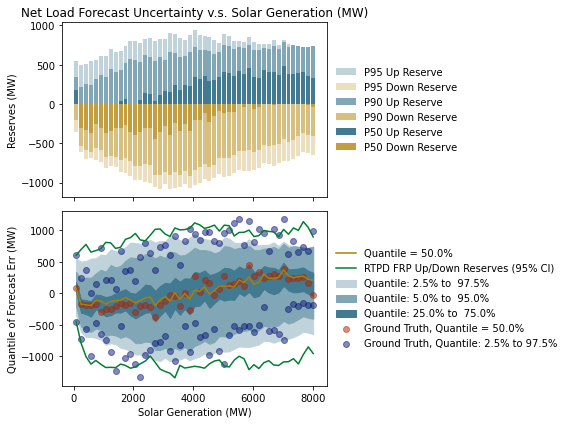

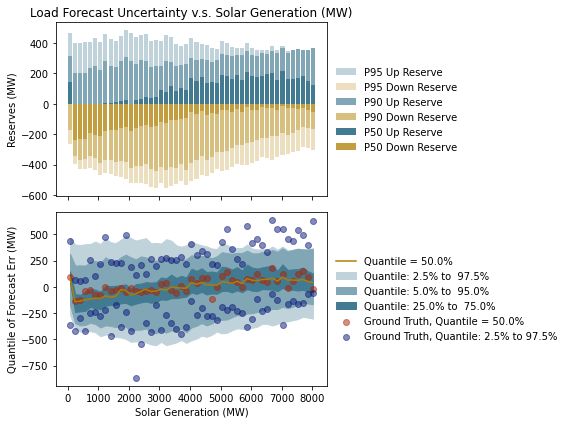

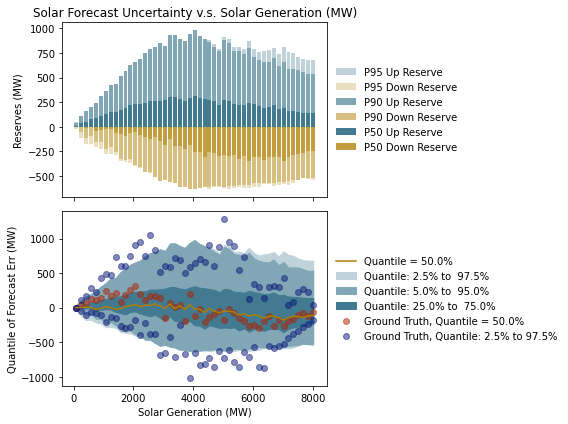

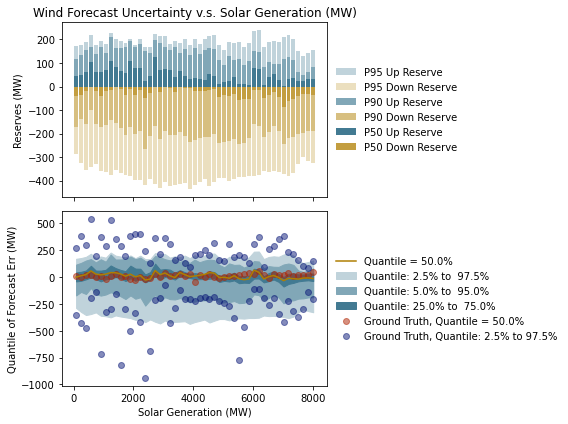

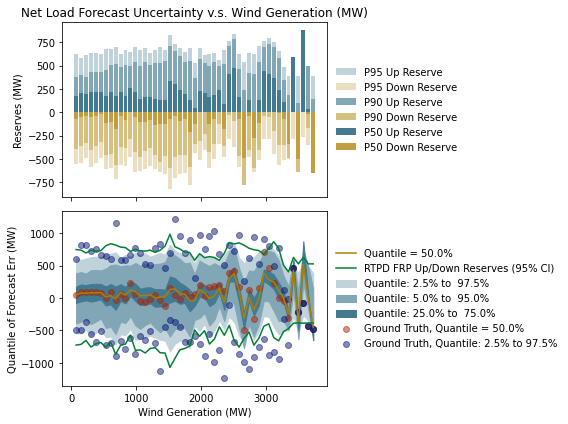

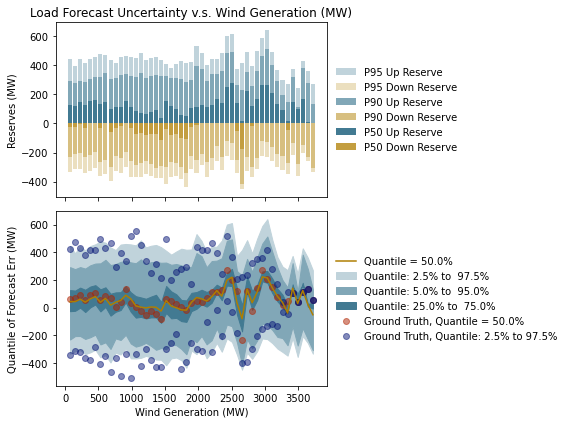

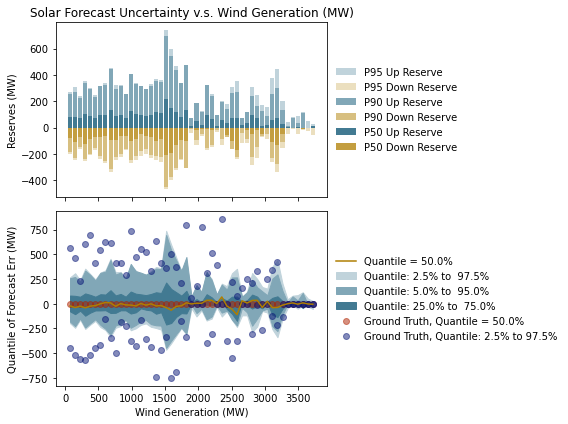

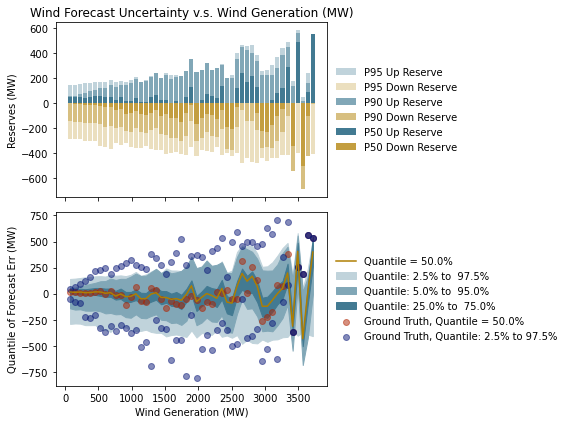

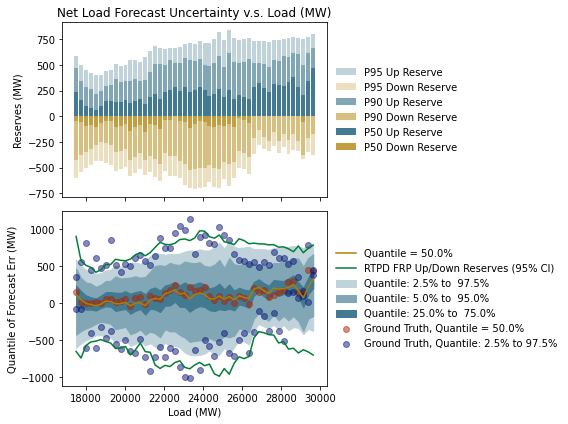

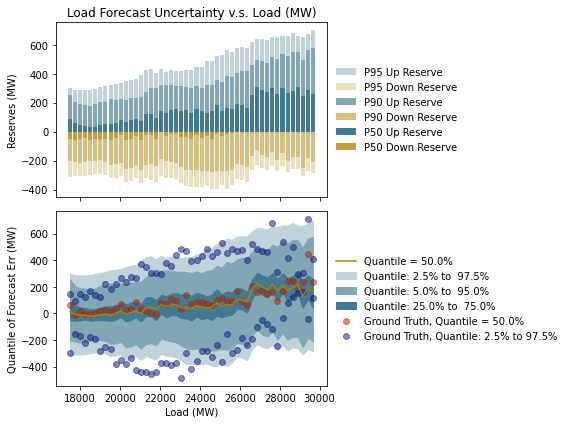

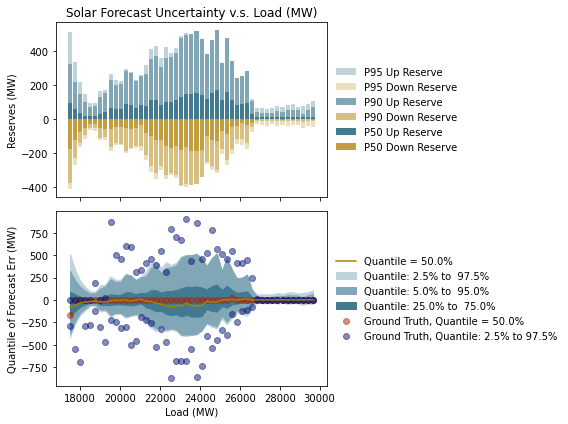

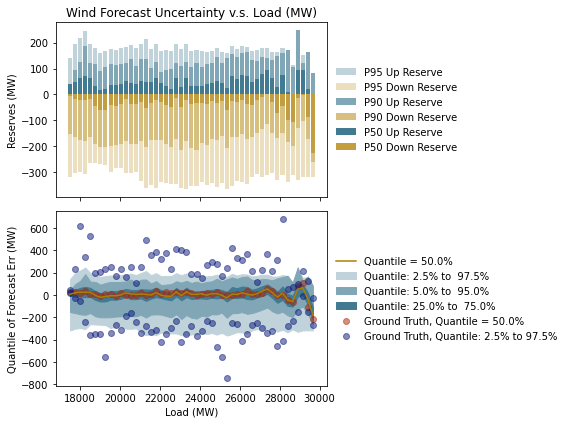

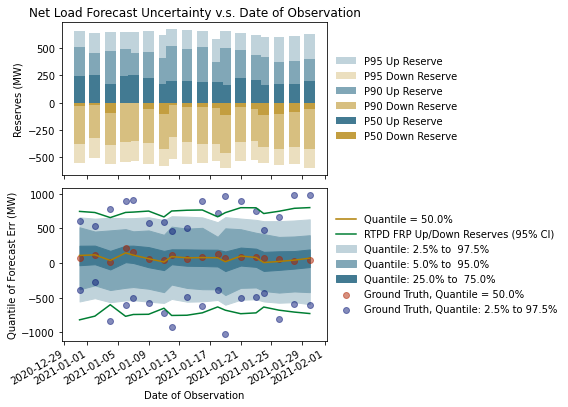

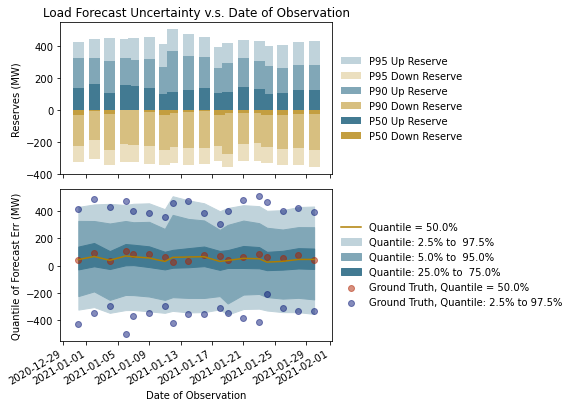

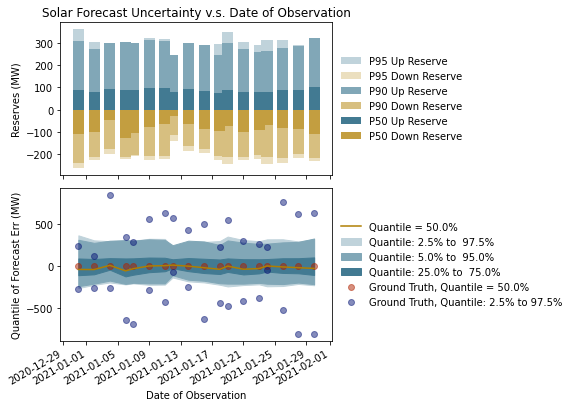

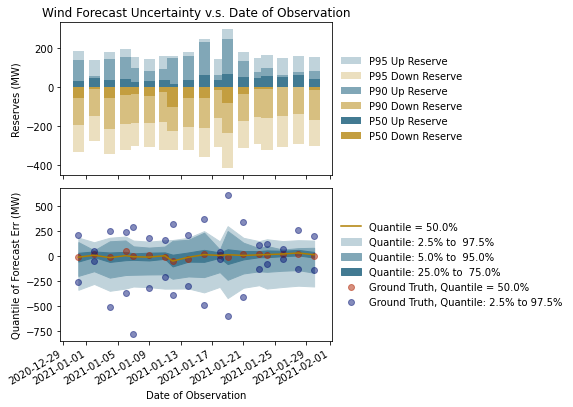

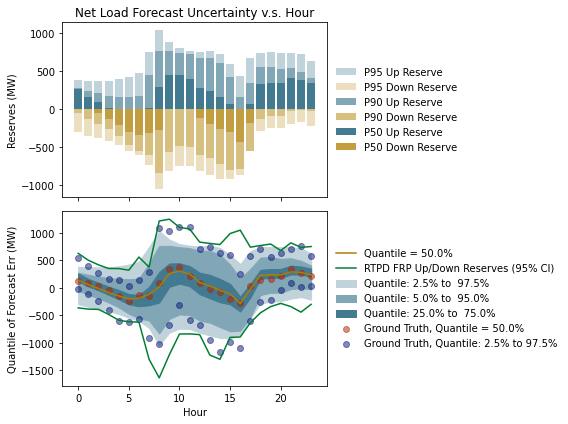

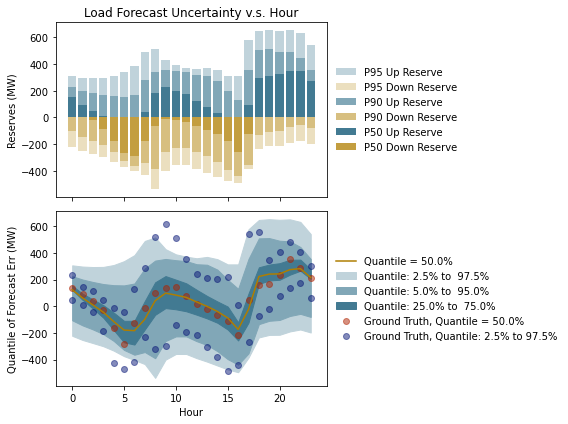

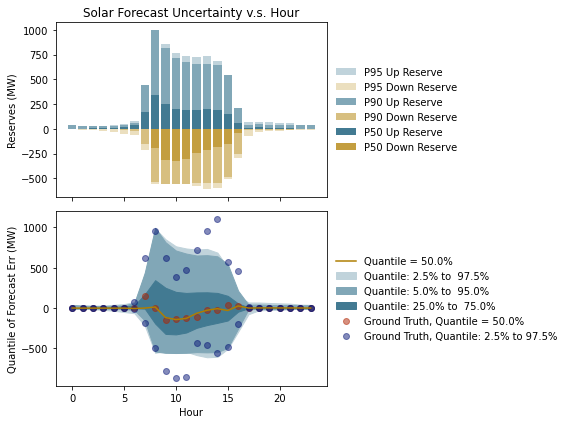

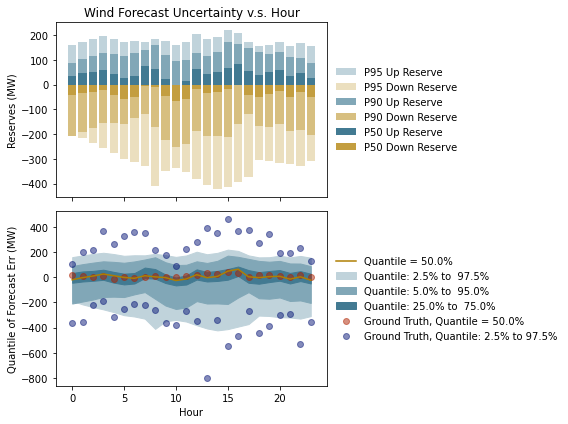

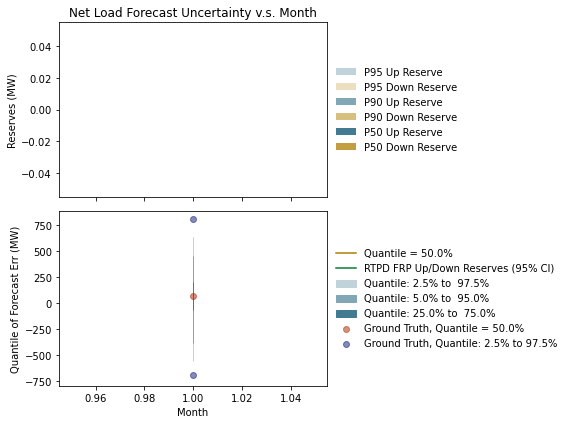

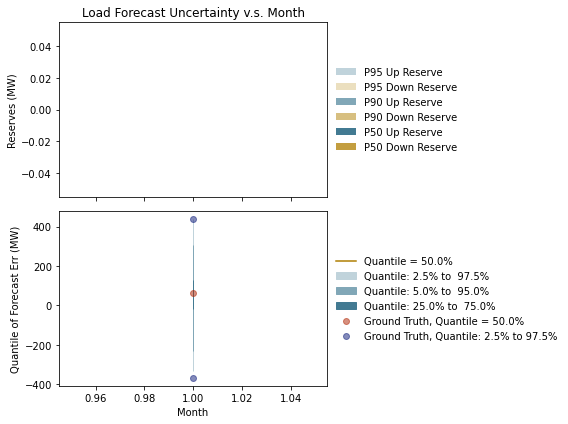

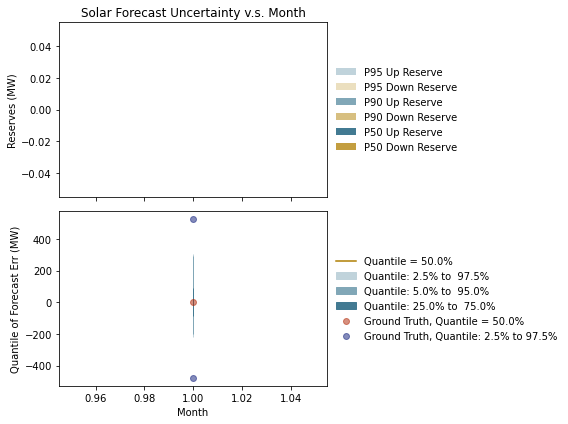

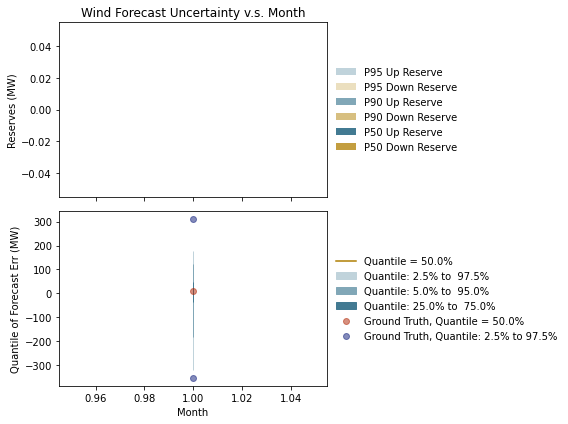

In [23]:
# Demonstrate the change in forecast uncertainty with respect to Solar, wind and load
for feature, label in label_to_feature_map.items():
    # if looking at Hour and Month, binning is derived from index
    if label == "Hour":
        feature_discretized = pred_trainval_diag.index.hour
    elif label == 'Month':
        feature_discretized = pred_trainval_diag.index.month
    else:
        # else the label is derived from dicretizing a continuous input
        feature_discretized = diagnostics.discretize_input(input_trainval_diag[feature])
        if label == 'Date of Observation':
            # TODO: Delete print stmts in this section
            print("Before changes")
            print(feature_discretized)
            # for 'Date of Observation', we add the starting date so it shows up as a historical data
            print(feature_discretized.astype('int'))
            print(input_trainval_diag.index[0].date())
            feature_discretized = (pd.Timestamp(input_trainval_diag.index[0].date()) 
                                   + feature_discretized[0].astype('int')*pd.Timedelta('1D'))
            print("After changes")
            print(feature_discretized)
    # Plotting the uncertainty (of each model output) and bias for each feature bin
    for response, response_label in label_to_response_map.items():
        pred_trainval_for_current_response = pred_trainval_diag.xs(key = response, axis = 1, level = 'Output_Name')
        # Feed in actual RTPD reserves to overlay on net load graphs
        if response_label == "Net Load":
            hist_rtpd_res_data = hist_rtpd_reserves
        else:
            hist_rtpd_res_data = None
        # Feed in actual inputs and outputs for current selection of feature and response to be overlaid on top of
        # graph showing forecast error uncertainty
        trainval_inputs_current_feature = input_trainval_diag[feature]
        trainval_outputs_current_response = output_trainval_diag[response]  
        # Make plot with chosen specifications       
        fig, axarr = diagnostics.plot_uncertainty_groupedby_feature(pred_trainval_for_current_response, feature_discretized, 
                                                                label_to_feature_map[feature], response_label,
                                                                trainval_inputs_current_feature,
                                                                trainval_outputs_current_response,
                                                                hist_rtpd_res_data)
    
        # Special formatting of the x axis when we are using date observation
        # TODO: Fix dates when only a subset of the total dataset is being plotted
        if label == 'Date of Observation':
            fig.autofmt_xdate()

        # Save fig if user so desires
        if save_fig_flag:
            fig_file_name = "{}_vs_{}_year_{}_mth_{}.svg".format(response_label, label, 
                                                                 str(diagnostics_for_year), str(diagnostics_for_month))
            fig.savefig(os.path.join(dir_str.plots_dir, fig_file_name), dpi = default_dpi)
                

## 5.3 Comparison of Predictions to Truth
Visualize and compare the model predictions to the ground truth for points that lie at the very edge of the desired prediction interval in each hour. True reserves held can be overlaid on top for comparison with model predicted reserves

**What to expect from a well trained model:** <br>
1. True forecast errors are generally comprised within model predictions
2. Model's predictions doesn't fall well beyond true forecast errors all the time - which would be an indication that the model is being too conservative and thus wasteful of reserves
3. Median quantile of true forecast errors matches well with median quantile of model predictions of forecast errors



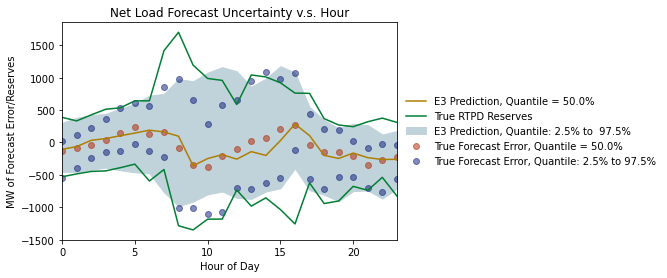

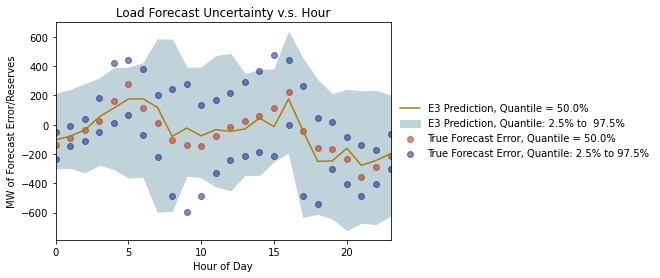

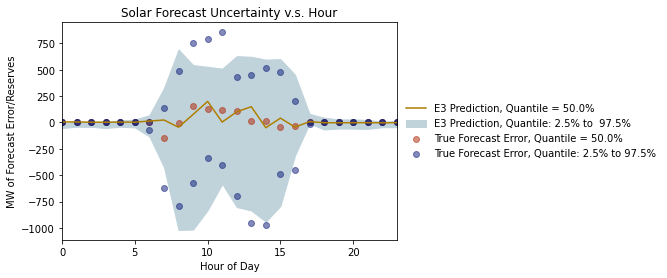

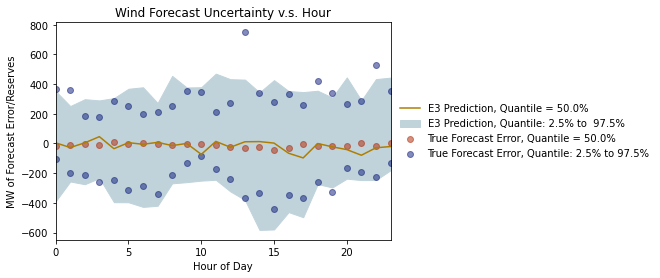

In [10]:
# Plot to compare model predictions to truth at critical quantiles in each hour
feature = "Hour_Angle_T+1"
label = "Hour"
# Plotting each model output 
for response, response_label in label_to_response_map.items():
    pred_trainval_for_current_response = pred_trainval_diag.xs(key = response, axis = 1, level = 'Output_Name')
    # Feed in actual RTPD reserves to overlay on net load graphs
    if response_label == "Net Load":
        hist_rtpd_res_data = hist_rtpd_reserves
    else:
        hist_rtpd_res_data = None
    # Feed in ground truth for current selection of response to be overlaid on top of graph showing model output
    trainval_outputs_current_response = output_trainval_diag[response]  
    # Make plot with these specifications
    fig, ax, truth_df, pred_df = diagnostics.compare_predictions_to_truth(pred_trainval_for_current_response, 
                                                       label_to_feature_map[feature], response_label,
                                                       trainval_outputs_current_response,
                                                       hist_rtpd_res_data, switch_forecast_direction_flag)
    # Save fig is user so desires
    if save_fig_flag:
        fig_file_name = response_label + "_compared_to_truth_in_month_{}_of_year_{}.svg".format(diagnostics_for_month,
                                                                                          diagnostics_for_year)
        fig.savefig(os.path.join(dir_str.plots_dir, fig_file_name), 
                    dpi = default_dpi,
                    bbox_inches = "tight")
    
    # Save the net load data being plotted if the user so desires
    if response_label == "Net Load":
        if save_net_load_pred_truth_data_flag:
            truth_file_name = "True_" + response_label + "_error_in_month_{}_of_year_{}.csv".format(diagnostics_for_month,
                                                                                          diagnostics_for_year)
            truth_df.to_csv(os.path.join(dir_str.diag_dir, truth_file_name))
            pred_file_name = "Predicted_" + response_label + "_error_in_month_{}_of_year_{}.csv".format(diagnostics_for_month,
                                                                                          diagnostics_for_year)
            pred_df.to_csv(os.path.join(dir_str.diag_dir, pred_file_name))
        


## 5.4 Model performance in different CV folds
Visualizing model performance for all the cross validation folds across training and validation sets. An important tool in assessing the generalizability of the model.

**What to look for:**
1. Distance between training and validation. Smaller distance signifies a small amount of expected performance drop betweeen seen and unseen data, hence better generalizability.
2. Spread among different validation folds: The smaller the spread, the more invariant the model is to its data, and hence better generalizability.

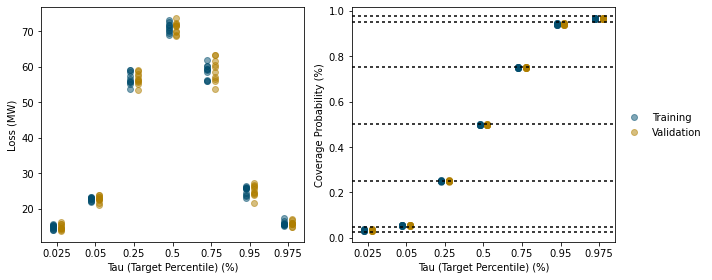

In [11]:
fig, _ =  diagnostics.plot_compare_train_val(training_hist, PI_percentiles,      
                                             metrics_to_idx_map, metrics_to_compare, x_jitter =x_jitter)
if save_fig_flag:
    fig.savefig(os.path.join(dir_str.plots_dir, 'Train_Val_Comparison.png'), dpi=default_dpi, bbox_inches = 'tight')

## 5.5 Example Time series
Visualize the quantile forecast for a few example days.


**What to look for**:
1. **Smoothness**: Is the reserve interval band changing continuously?
2. **Coverage**: How good is the reserve interval band covering the true forecast error? The more the better.
3. **Exceeding**: What kind of condition seems to lead to exceedance? Hopefully it should be extreme

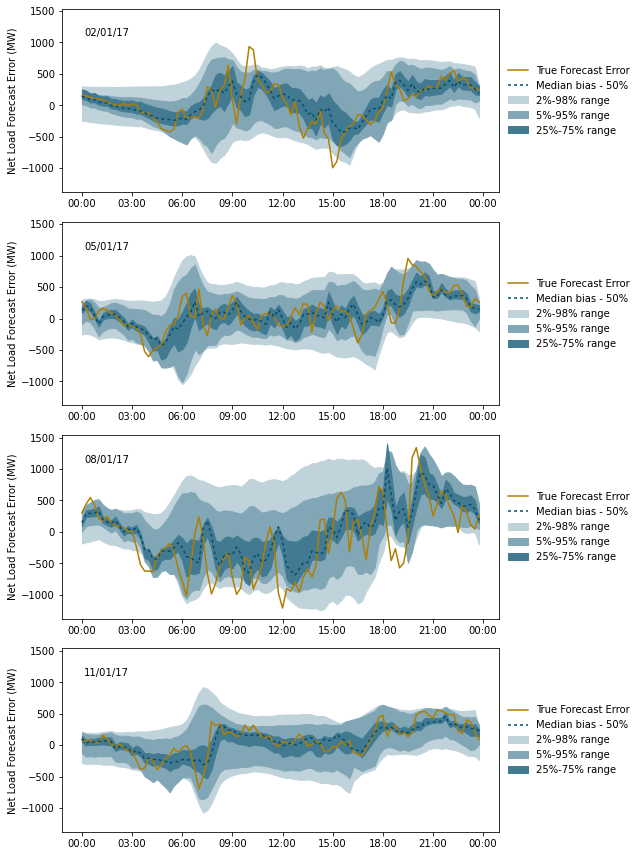

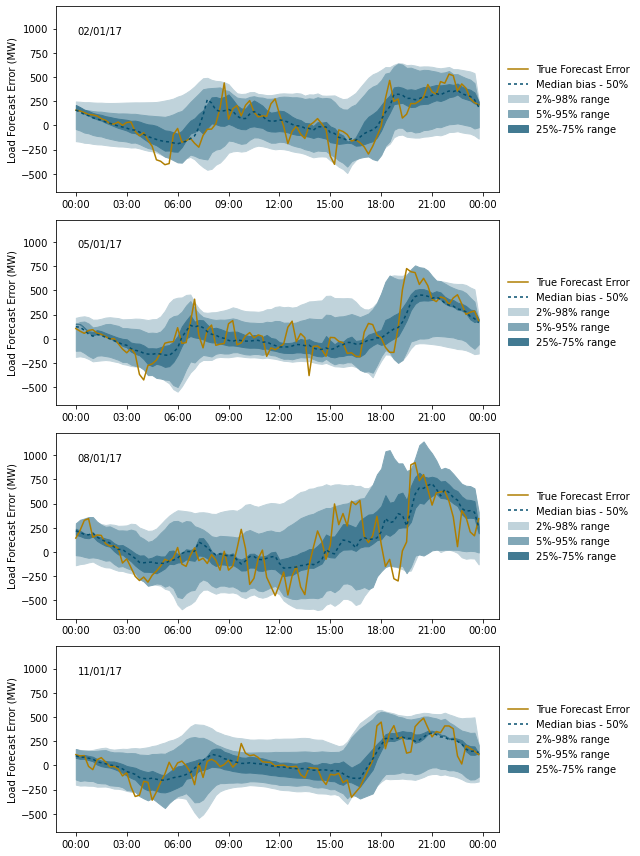

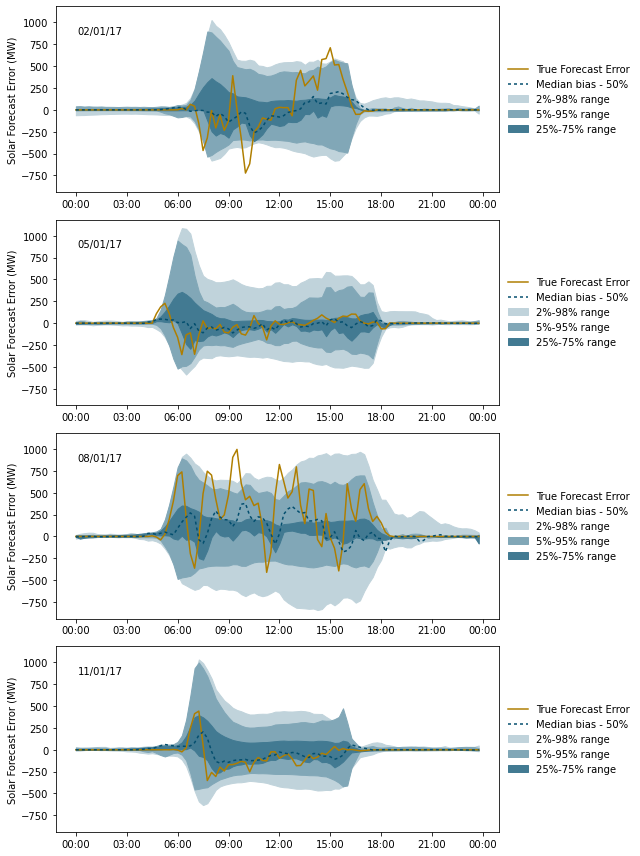

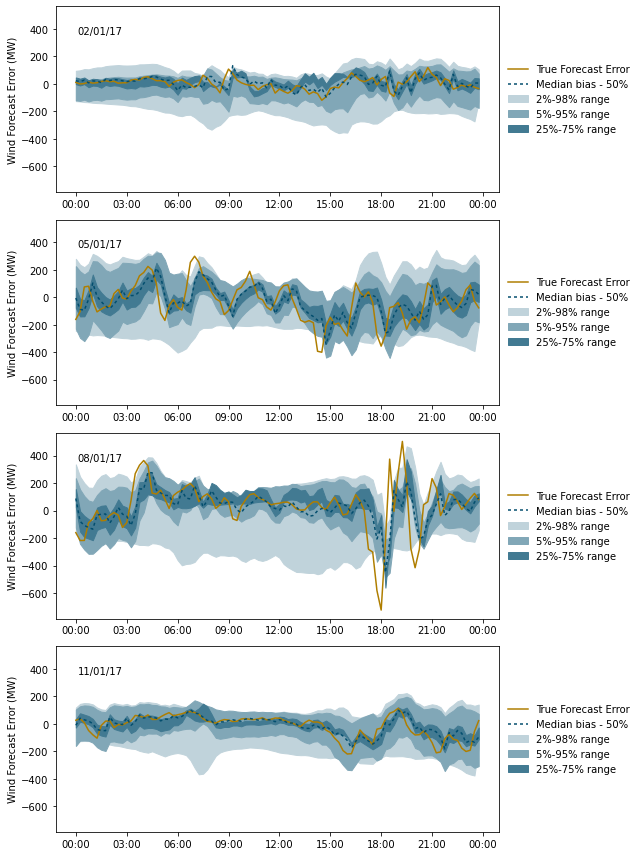

In [12]:
for response, response_label in label_to_response_map.items():
    pred_trainval_for_current_response = pred_trainval.xs(key = response, axis = 1, level = 'Output_Name')
    output_trainval_for_current_response = output_trainval[response]
    fig, axarr = diagnostics.plot_example_ts(ts_ranges, pred_trainval_for_current_response, 
                                             output_trainval_for_current_response, response_label)
    if save_fig_flag:
        fig_file_name = "{}_on_chosen_specific_days.svg".format(response_label)
        fig.savefig(os.path.join(dir_str.plots_dir,fig_file_name), 
                    dpi = default_dpi, bbox_inches = 'tight')


Archived code: Use `tf.GradientTape` for very fine grained control.

In [9]:
# train_loss = tf.keras.metrics.Mean(name='train_loss')
# test_loss = tf.keras.metrics.Mean(name='test_loss')

# @tf.function
# def train_step(inputs, outputs, model, loss_fn):
#     with tf.GradientTape() as tape:
#         # training=True is only needed if there are layers with different
#         # behavior during training versus inference (e.g. Dropout).
#         predictions = model(inputs, training=True)
#         loss = loss_fn(outputs, predictions)
#     gradients = tape.gradient(loss, rescue.trainable_variables)
#     optimizer.apply_gradients(zip(gradients, rescue.trainable_variables))

#     train_loss(loss)
#     #train_accuracy(outputs, predictions)


# @tf.function
# def test_step(inputs, outputs, model, loss_fn):
#     # training=False is only needed if there are layers with different
#     # behavior during training versus inference (e.g. Dropout).
#     predictions = rescue(inputs, training=False)
#     t_loss = loss_object(outputs, predictions)

#     test_loss(t_loss)
#     #test_accuracy(outputs, predictions)

# EPOCHS = 5

# for epoch in range(EPOCHS):
#   # Reset the metrics at the start of the next epoch
#   train_loss.reset_states()
#   #train_accuracy.reset_states()
#   test_loss.reset_states()
#   #test_accuracy.reset_states()

#   for inputs, outputs in train_ds:
#     train_step(inputs, outputs)

#   for test_inputs, test_outputs in test_ds:
#     test_step(test_inputs, test_outputs)

#   print(
#     f'Epoch {epoch + 1}, '
#     f'Loss: {train_loss.result()}, '
#     #f'Accuracy: {train_accuracy.result() * 100}, '
#     f'Test Loss: {test_loss.result()}, '
#     #f'Test Accuracy: {test_accuracy.result() * 100}'
#   )